# Lesson 1

## 1. Objectives

The main objective of this notebook is to replicate the results from the first lesson of Fast AI course (https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson1.ipynb).

I decided to do the following:
1. Create vgg16 model based on vgg16 class. It should be able to distinguish between cats and dogs.
2. Create vgg16 m

Data should be downloaded from http://files.fast.ai/data/dogscats.zip and put into data directory.

## 2. Setting up

In [1]:
%matplotlib inline
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [2]:
import utils; reload(utils)
from utils import plots

Using TensorFlow backend.
/Users/michalstechly/Documents/Fast_AI/fast-venv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [22]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [23]:
# path = os.path.join("..","data","dogscats")
path = os.path.join("..","data","dogscats","sample")

In [24]:
batch_size = 64

## 3. VGG16 model

In [25]:
network = Vgg16()

In [27]:
train_batches = network.get_batches(os.path.join(path, "train"))
validation_batches = network.get_batches(os.path.join(path, "valid"))
network.finetune(train_batches)

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [28]:
network.fit(train_batches, validation_batches)

Epoch 1/1
16/16 [==============================] - 63s - loss: 1.2089 - acc: 0.5625 - val_loss: 0.6022 - val_acc: 0.5000


In [29]:
batches = network.get_batches(os.path.join(path,"train"), batch_size=4)

Found 16 images belonging to 2 classes.


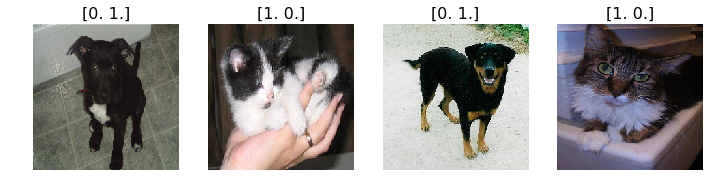

In [33]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

## 4. VGG16 from Keras